Using: cuda


100%|██████████| 9.91M/9.91M [00:02<00:00, 4.94MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 129kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 15.3MB/s]



===== Training with dropout = 0.0 =====
Epoch 1: Train 0.4144 | Val 0.2175 | Acc 0.9331
Epoch 2: Train 0.1715 | Val 0.1408 | Acc 0.9559
Epoch 3: Train 0.1278 | Val 0.1263 | Acc 0.9619
Epoch 4: Train 0.0996 | Val 0.1269 | Acc 0.9617
Epoch 5: Train 0.0822 | Val 0.1030 | Acc 0.9672

===== Training with dropout = 0.1 =====
Epoch 1: Train 0.4296 | Val 0.2121 | Acc 0.9321
Epoch 2: Train 0.1844 | Val 0.1511 | Acc 0.9539
Epoch 3: Train 0.1470 | Val 0.1229 | Acc 0.9611
Epoch 4: Train 0.1246 | Val 0.1233 | Acc 0.9627
Epoch 5: Train 0.1070 | Val 0.0914 | Acc 0.9722

===== Training with dropout = 0.3 =====
Epoch 1: Train 0.5382 | Val 0.2107 | Acc 0.9335
Epoch 2: Train 0.2605 | Val 0.1577 | Acc 0.9518
Epoch 3: Train 0.2128 | Val 0.1416 | Acc 0.9555
Epoch 4: Train 0.1898 | Val 0.1345 | Acc 0.9586
Epoch 5: Train 0.1745 | Val 0.1148 | Acc 0.9643

===== Training with dropout = 0.5 =====
Epoch 1: Train 0.7587 | Val 0.2980 | Acc 0.9105
Epoch 2: Train 0.4278 | Val 0.2197 | Acc 0.9332
Epoch 3: Train 0.358

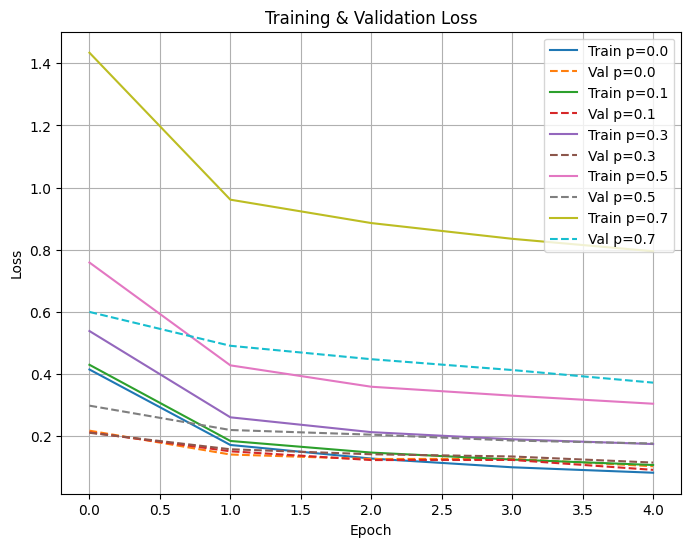

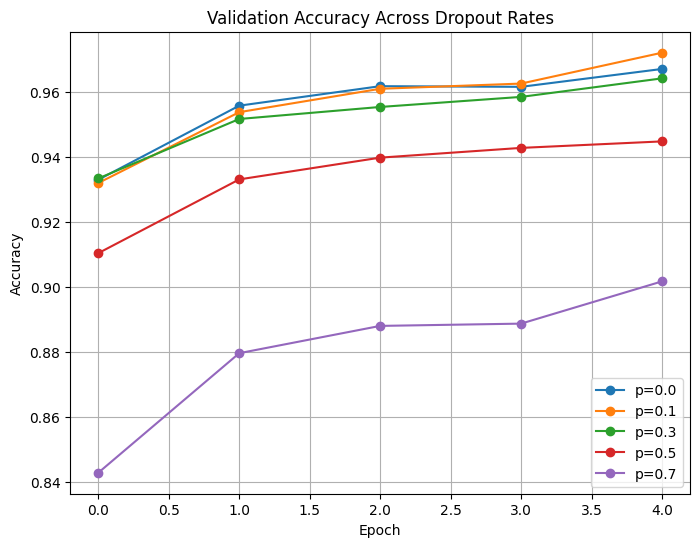

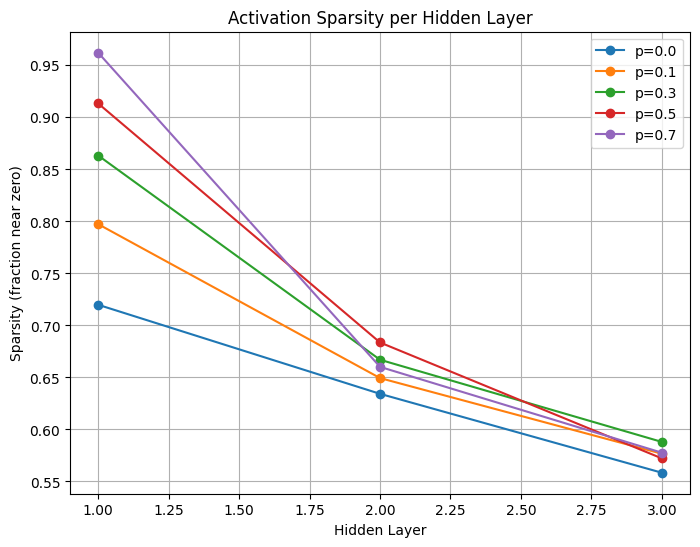

In [1]:
# ============================================================
# 1. IMPORTS
# ============================================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

# ============================================================
# 2. DATASET (MNIST)
# ============================================================
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

full_train = datasets.MNIST(root="data", train=True, download=True, transform=transform)
test_data = datasets.MNIST(root="data", train=False, download=True, transform=transform)

val_size = 10000
train_size = len(full_train) - val_size
train_data, val_data = random_split(full_train, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
val_loader = DataLoader(val_data, batch_size=128)
test_loader = DataLoader(test_data, batch_size=128)

# ============================================================
# 3. MODEL WITH DROPOUT AS HYPERPARAMETER
# ============================================================
class MLP(nn.Module):
    def __init__(self, dropout=0.0):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(256, 10)
        )
        self.dropout = dropout

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        return self.layers(x)

# ============================================================
# 4. TRAINING / EVALUATION
# ============================================================
criterion = nn.CrossEntropyLoss()

def train_epoch(model, loader, optimizer):
    model.train()
    total_loss = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
    return total_loss / len(loader.dataset)

def evaluate(model, loader):
    model.eval()
    total_loss = 0
    correct = 0
    preds_list, labels_list = [], []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            output = model(x)
            loss = criterion(output, y)
            total_loss += loss.item() * x.size(0)

            preds = output.argmax(1)
            correct += (preds == y).sum().item()
            preds_list.extend(preds.cpu().numpy())
            labels_list.extend(y.cpu().numpy())

    accuracy = correct / len(loader.dataset)
    return total_loss / len(loader.dataset), accuracy, np.array(preds_list), np.array(labels_list)

# ============================================================
# 5. REPRESENTATION SPARSITY (ACTIVATIONS)
# ============================================================
def get_sparsity(model, loader, threshold=1e-3):
    activations = []

    def hook(module, inp, out):
        activations.append(out.detach().cpu())

    hooks = []
    for layer in model.layers:
        if isinstance(layer, nn.ReLU):
            hooks.append(layer.register_forward_hook(hook))

    model.eval()
    with torch.no_grad():
        for i, (x, _) in enumerate(loader):
            x = x.to(device)
            model(x)
            if i == 30: break

    for h in hooks:
        h.remove()

    layer_sparsity = []
    num_relus = sum(1 for l in model.layers if isinstance(l, nn.ReLU))
    layer_chunks = [activations[i::num_relus] for i in range(num_relus)]

    for chunk in layer_chunks:
        act = torch.cat(chunk, dim=0)
        sparse = (act.abs() < threshold).float().mean().item()
        layer_sparsity.append(sparse)

    return layer_sparsity

# ============================================================
# 6. MAIN EXPERIMENT LOOP
# ============================================================
dropout_rates = [0.0, 0.1, 0.3, 0.5, 0.7]
epochs = 5
results = {}

for p in dropout_rates:
    print(f"\n===== Training with dropout = {p} =====")
    model = MLP(dropout=p).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    train_losses, val_losses, val_accs = [], [], []

    for ep in range(epochs):
        t_loss = train_epoch(model, train_loader, optimizer)
        v_loss, v_acc, _, _ = evaluate(model, val_loader)

        train_losses.append(t_loss)
        val_losses.append(v_loss)
        val_accs.append(v_acc)

        print(f"Epoch {ep+1}: Train {t_loss:.4f} | Val {v_loss:.4f} | Acc {v_acc:.4f}")

    test_loss, test_acc, preds, labels = evaluate(model, test_loader)
    cm = confusion_matrix(labels, preds)
    sparsity = get_sparsity(model, val_loader)

    results[p] = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "val_accs": val_accs,
        "test_loss": test_loss,
        "test_acc": test_acc,
        "confusion_matrix": cm,
        "sparsity": sparsity
    }

# ============================================================
# 7. PLOTS
# ============================================================

# Loss curves
plt.figure(figsize=(8,6))
for p in dropout_rates:
    plt.plot(results[p]["train_losses"], label=f"Train p={p}")
    plt.plot(results[p]["val_losses"], linestyle="--", label=f"Val p={p}")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Accuracy curves
plt.figure(figsize=(8,6))
for p in dropout_rates:
    plt.plot(results[p]["val_accs"], marker="o", label=f"p={p}")
plt.title("Validation Accuracy Across Dropout Rates")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Sparsity plot
plt.figure(figsize=(8,6))
layers = [1,2,3]
for p in dropout_rates:
    plt.plot(layers, results[p]["sparsity"], marker="o", label=f"p={p}")
plt.title("Activation Sparsity per Hidden Layer")
plt.xlabel("Hidden Layer")
plt.ylabel("Sparsity (fraction near zero)")
plt.legend()
plt.grid(True)
plt.show()
